# Gaussian Stochastic Volatility Model 

In [439]:
using Gen
using Random
using Statistics
using Plots
using GenParticleFilters
using Distributions

In [440]:

@gen function sv_model(T::Int)
    # priors - explained in report
    # Mean of log-volatility
    mu = {:mu} ~ normal(0.0, 1.0)
    
    # Persistence parameter
    phi = {:phi} ~ uniform(-0.99, 0.99)

    # Volatility of log-volatility
    sigma = {:sigma} ~ Gen.gamma(2.0, 0.5)  # shape=2, scale=0.5, mean=1.0

    # Latent log-volatility process (AR(1)) - built incrementally for HMC compatibility
    # First state: draw from stationary distribution
    # Stationary variance of AR(1) is : σ² / (1 - φ²)
    h1_std = sigma / sqrt(1 - phi^2)
    h_prev = {(:h, 1)} ~ normal(mu, h1_std)
    
    # Observations - generate incrementally
    y_std_1 = exp(h_prev / 2)
    {(:y, 1)} ~ normal(0.0, y_std_1)
    
    # Subsequent states: AR(1) transitions
    for t in 2:T
        h_mean = mu + phi * (h_prev - mu)
        h_prev = {(:h, t)} ~ normal(h_mean, sigma)
        
        # Observation for this timestep
        y_std = exp(h_prev / 2)
        {(:y, t)} ~ normal(0.0, y_std)
    end
    
    return nothing  # Don't return arrays to avoid AD issues with HMC
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], Main.var"##sv_model#558", Bool[0], false)

In [441]:

function simulate_data(T::Int; seed::Int=42)
    Random.seed!(seed)
    
    trace = Gen.simulate(sv_model, (T,))
    
    # ture params from trace
    μ_true = trace[:mu]
    φ_true = trace[:phi]
    σ_true = trace[:sigma]
    
    # latent states and observations from trace
    h = [trace[(:h, t)] for t in 1:T]
    y = [trace[(:y, t)] for t in 1:T]
    
    true_params = (μ=μ_true, φ=φ_true, σ=σ_true)
    
    return trace, y, true_params, h
end

simulate_data (generic function with 1 method)

In [442]:
# Simulate synthetic data
T = 200  # time series length
seed = 243

println("Simulating stochastic volatility data (T=$T)")
println("=" ^ 50)

trace, y, true_params, h_true = simulate_data(T; seed=seed)

println("\nTrue parameters:")
println("  μ (mean log-vol)     = $(true_params.μ)")
println("  φ (persistence)      = $(true_params.φ)")
println("  σ (vol of log-vol)   = $(true_params.σ)")

# Compute volatility from log-volatility
vol_true = exp.(h_true ./ 2)


println("\nData summary:")
println("  y (returns) range: [$(minimum(y)), $(maximum(y))]")
println("  Volatility range:  [$(minimum(vol_true)), $(maximum(vol_true))]")


Simulating stochastic volatility data (T=200)

True parameters:
  μ (mean log-vol)     = -0.9152001908817212
  φ (persistence)      = -0.6665879866183708
  σ (vol of log-vol)   = 0.2860575490861575

Data summary:
  y (returns) range: [-2.0055154798986212, 1.8275109663465436]
  Volatility range:  [0.35219373668847065, 1.0366629867942116]


## Visualize the Simulated Data

Plot the returns, latent log-volatility, and volatility time series.

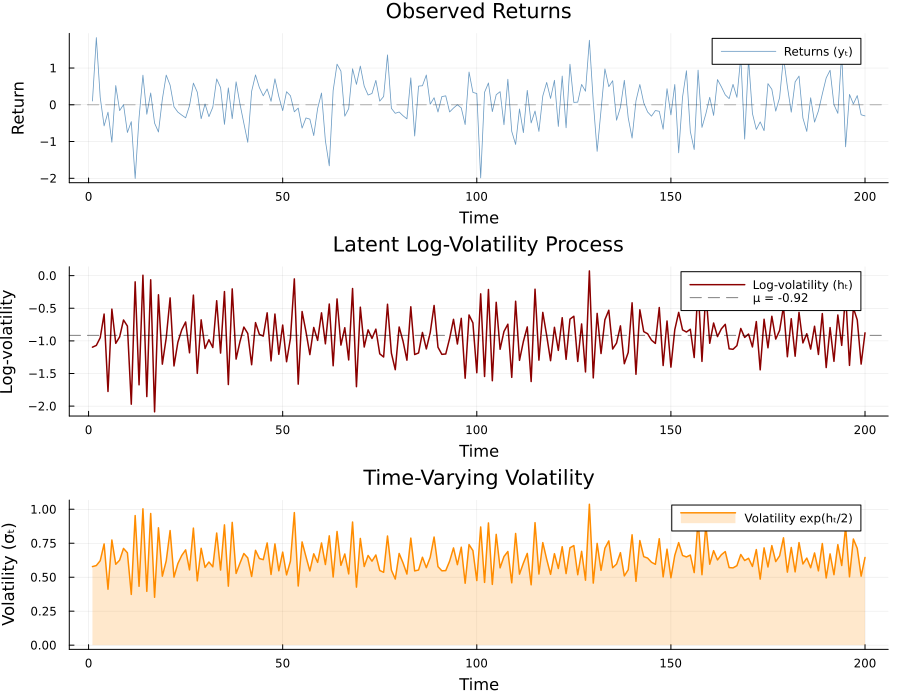

In [443]:
using Plots

ts = 1:T

# Plot 1: Returns (observed data)
p1 = plot(ts, y,
    label="Returns (yₜ)",
    linewidth=0.8,
    color=:steelblue,
    xlabel="Time",
    ylabel="Return",
    title="Observed Returns",
    alpha=0.8)
hline!(p1, [0], color=:black, linestyle=:dash, label="", alpha=0.3)

# Plot 2: Latent log-volatility process
p2 = plot(ts, h_true,
    label="Log-volatility (hₜ)",
    linewidth=1.5,
    color=:darkred,
    xlabel="Time",
    ylabel="Log-volatility",
    title="Latent Log-Volatility Process")
hline!(p2, [true_params.μ], color=:black, linestyle=:dash, 
    label="μ = $(round(true_params.μ, digits=2))", alpha=0.5)

# Plot 3: Volatility (standard deviation of returns)
p3 = plot(ts, vol_true,
    label="Volatility exp(hₜ/2)",
    linewidth=1.5,
    color=:darkorange,
    xlabel="Time",
    ylabel="Volatility (σₜ)",
    title="Time-Varying Volatility",
    fill=0, fillalpha=0.2)

# Combined layout
plot(p1, p2, p3, layout=(3, 1), size=(900, 700), legend=:topright)

# Inference

## Importance Sampling

We'll use importance sampling to infer the latent log-volatility states and model parameters given the observed returns.

In [444]:
function make_y_constraints(y_obs)
    T = length(y_obs)
    constraints = Gen.choicemap()
    for t in 1:T
        constraints[(:y, t)] = y_obs[t]
    end
    return constraints
end

function infer_is(T::Int, y_obs; N=2_000)
    constraints = make_y_constraints(y_obs)
    
    traces, log_normalized_weights, log_ml_estimate = Gen.importance_sampling(sv_model, (T,), constraints, N)
    
    return traces, log_normalized_weights, log_ml_estimate
end

function extract_params(trace)
    choices = Gen.get_choices(trace)
    
    μ = choices[:mu]
    φ = choices[:phi]
    σ = choices[:sigma]
    
    return (μ=μ, φ=φ, σ=σ)
end

function extract_latent_states(trace, T)
    choices = Gen.get_choices(trace)
    h = [choices[(:h, t)] for t in 1:T]
    return h
end

extract_latent_states (generic function with 2 methods)

In [445]:
# Run importance sampling inference

@time traces, log_weights, log_ml_estimate = infer_is(T, y, N=2000)

  0.877836 seconds (6.52 M allocations: 265.576 MiB, 32.48% gc time, 2.91% compilation time)


(Gen.DynamicDSLTrace[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], Main.var"##sv_model#558", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:h, 33) => Gen.ChoiceOrCallRecord{Float64}(-2.189299992059536, -1.6290431709265478, NaN, true), (:h, 137) => Gen.ChoiceOrCallRecord{Float64}(-3.331938149911749, -0.5289024339848377, NaN, true), (:y, 46) => Gen.ChoiceOrCallRecord{Float64}(0.4304220817038666, -0.9355875125999145, NaN, true), (:y, 50) => Gen.ChoiceOrCallRecord{Float64}(-0.15903656136246322, -0.4268842022912348, NaN, true), (:y, 134) => Gen.ChoiceOrCallRecord{Float64}(0.49272220873954536, -1.2185199030621143, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(0.19994237603214515, -0.6669820545834975, NaN, true), (:h, 185) => Gen.ChoiceOrCallRecord{Float64}(-2.8565666482225893, -1.687471818887654, NaN, true), (:y, 29) => Gen.

In [446]:
# Extract parameters from all posterior samples
posterior_params = [extract_params(tr) for tr in traces]

# Compute posterior statistics
μs = [p.μ for p in posterior_params]
φs = [p.φ for p in posterior_params]
σs = [p.σ for p in posterior_params]

println("\nPosterior parameter estimates (mean ± std):")
println("  μ (mean log-vol):    $(round(mean(μs), digits=4)) ± $(round(std(μs), digits=4))  (true: $(round(true_params.μ, digits=4)))")
println("  φ (persistence):     $(round(mean(φs), digits=4)) ± $(round(std(φs), digits=4))  (true: $(round(true_params.φ, digits=4)))")
println("  σ (vol of log-vol):  $(round(mean(σs), digits=4)) ± $(round(std(σs), digits=4))  (true: $(round(true_params.σ, digits=4)))")


Posterior parameter estimates (mean ± std):
  μ (mean log-vol):    -0.0255 ± 0.9728  (true: -0.9152)
  φ (persistence):     0.0037 ± 0.5812  (true: -0.6666)
  σ (vol of log-vol):  0.9774 ± 0.6584  (true: 0.2861)


## Metropolis-Hastings 


In [448]:
function infer_mh(T, y_obs; n_samples=2000)
    constraints = make_y_constraints(y_obs)
    
    # Initialize trace from the prior constrained to observations
    trace, _ = Gen.generate(sv_model, (T,), constraints)
    
    println("Starting MCMC with $(n_samples) samples")
    
    traces = []
    accept_count = 0
    
    
    for i in 1:n_samples
        new_trace, accepted = Gen.mh(trace, Gen.select(:mu, :phi, :sigma))
        if accepted
            accept_count += 1
        end
        trace = new_trace
        
        for t in 1:T
            trace, _ = Gen.mh(trace, Gen.select((:h, t)))
        end
        
        push!(traces, trace)
        
        # Progress reporting
        if i % 500 == 0
            println("  Collected $i samples...")
        end
    end
    
    println("Sampling complete. Acceptance rate: $(round(accept_count/n_samples, digits=3))")
    
    return traces
end

infer_mh (generic function with 2 methods)

In [449]:
# Run Metropolis-Hastings inference
println("Metropolis-Hastings")

@time traces_mh = infer_mh(T, y, n_samples=2000)

println("\nNumber of posterior samples (MCMC): $(length(traces_mh))")

Metropolis-Hastings
Starting MCMC with 2000 samples...
  Collected 500 samples...
  Collected 1000 samples...
  Collected 1500 samples...
  Collected 2000 samples...
Sampling complete. Acceptance rate: 0.002
 84.222212 seconds (2.12 G allocations: 69.070 GiB, 16.20% gc time, 0.04% compilation time: 77% of which was recompilation)

Number of posterior samples (MCMC): 2000


In [450]:
# Extract parameters from MCMC posterior samples
posterior_params_mh = [extract_params(tr) for tr in traces_mh]

# Compute posterior statistics
μs_mh = [p.μ for p in posterior_params_mh]
φs_mh = [p.φ for p in posterior_params_mh]
σs_mh = [p.σ for p in posterior_params_mh]

println("MCMC Posterior parameter estimates (mean ± std):")
println("  μ (mean log-vol):    $(round(mean(μs_mh), digits=4)) ± $(round(std(μs_mh), digits=4))  (true: $(round(true_params.μ, digits=4)))")
println("  φ (persistence):     $(round(mean(φs_mh), digits=4)) ± $(round(std(φs_mh), digits=4))  (true: $(round(true_params.φ, digits=4)))")
println("  σ (vol of log-vol):  $(round(mean(σs_mh), digits=4)) ± $(round(std(σs_mh), digits=4))  (true: $(round(true_params.σ, digits=4)))")

MCMC Posterior parameter estimates (mean ± std):
  μ (mean log-vol):    -0.9147 ± 0.1134  (true: -0.9152)
  φ (persistence):     0.4542 ± 0.0508  (true: -0.6666)
  σ (vol of log-vol):  0.9145 ± 0.0923  (true: 0.2861)


### MCMC Trace Plots

Visualize the MCMC chains to check for convergence and mixing.

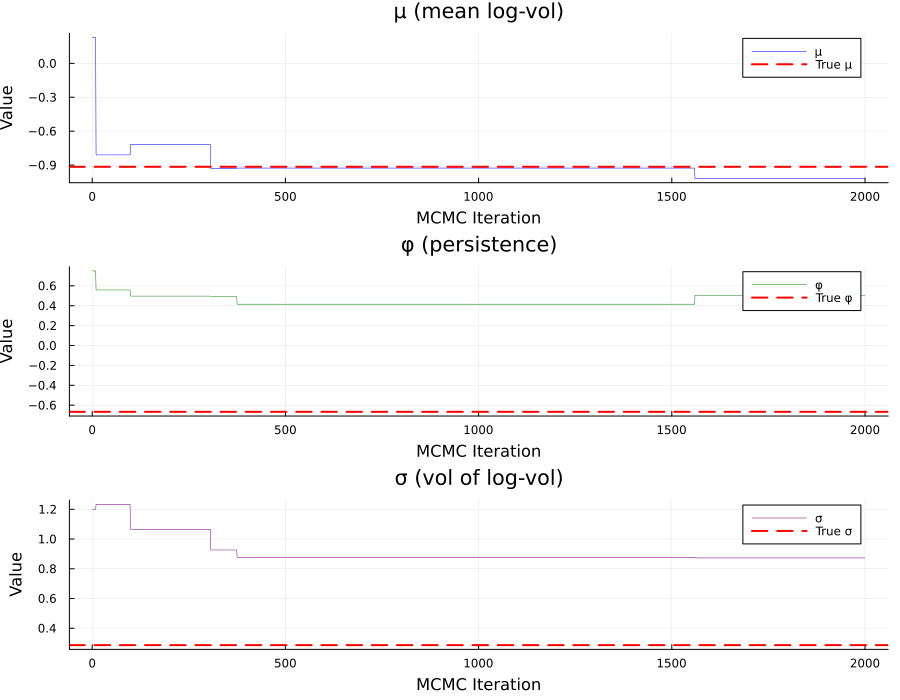

In [451]:
# Trace plots for MCMC diagnostics
p1 = plot(μs_mh, label="μ", xlabel="MCMC Iteration", ylabel="Value", 
          title="μ (mean log-vol)", linewidth=0.5, color=:blue)
hline!(p1, [true_params.μ], label="True μ", linestyle=:dash, color=:red, linewidth=2)

p2 = plot(φs_mh, label="φ", xlabel="MCMC Iteration", ylabel="Value", 
          title="φ (persistence)", linewidth=0.5, color=:green)
hline!(p2, [true_params.φ], label="True φ", linestyle=:dash, color=:red, linewidth=2)

p3 = plot(σs_mh, label="σ", xlabel="MCMC Iteration", ylabel="Value", 
          title="σ (vol of log-vol)", linewidth=0.5, color=:purple)
hline!(p3, [true_params.σ], label="True σ", linestyle=:dash, color=:red, linewidth=2)

plot(p1, p2, p3, layout=(3, 1), size=(900, 700), legend=:topright)

### MCMC Latent State Inference

Visualize the inferred latent volatility states from MCMC samples.

In [452]:
# Extract latent states from MCMC posterior samples
Random.seed!(42)
n_samples_mh = min(100, length(traces_mh))
sample_indices_mh = rand(1:length(traces_mh), n_samples_mh)

# Extract log-volatility trajectories
h_samples_mh = []
for idx in sample_indices_mh
    h = extract_latent_states(traces_mh[idx], T)
    push!(h_samples_mh, h)
end

println("Extracted $(length(h_samples_mh)) MCMC posterior samples of latent states")

Extracted 100 MCMC posterior samples of latent states


## Hamiltonian Monte Carlo (HMC)

HMC uses gradient information to propose better moves through parameter space, potentially leading to better exploration and faster convergence than random-walk MH. We'll use Gen's built-in HMC implementation.

In [453]:
function infer_hmc(T::Int, y_obs; n_samples=2000, eps=0.01, L=10)
    constraints = make_y_constraints(y_obs)
    
    
    
    trace, _ = Gen.generate(sv_model, (T,), constraints)

    
    println("Starting HMC with $(n_samples) samples")


    # Select all continuous variables for HMC
    selection = Gen.select(:mu, :phi, :sigma)
    for t in 1:T
        selection = Gen.select(selection, (:h, t))
    end
    
    
    traces = []
    accept_count = 0
    
    for i in 1:n_samples
        trace, accepted = Gen.hmc(trace, selection; eps=eps, L=L)
        if accepted
            accept_count += 1
        end
        
        push!(traces, trace)
        
        if i % 500 == 0
            println("  Collected $i samples, acceptance: $(round(accept_count/i, digits=3))")
        end
    end
    
   
    println("Sampling acceptance: $(round(accept_count/n_samples, digits=3))")
    
    return traces
end

infer_hmc (generic function with 1 method)

In [454]:
println("Hamiltonian Monte Carlo")

@time traces_hmc = infer_hmc(T, y, n_samples=2000, eps=0.6, L=30)

println("\nNumber of posterior samples (HMC): $(length(traces_hmc))")

Hamiltonian Monte Carlo
Starting HMC with 2000 samples
  Collected 500 samples, acceptance: 0.972
  Collected 1000 samples, acceptance: 0.977
  Collected 1500 samples, acceptance: 0.977
  Collected 2000 samples, acceptance: 0.978
Sampling acceptance: 0.978
 44.021475 seconds (808.50 M allocations: 26.686 GiB, 13.68% gc time, 0.36% compilation time)

Number of posterior samples (HMC): 2000


In [455]:
# Extract parameters from HMC posterior samples
posterior_params_hmc = [extract_params(tr) for tr in traces_hmc]

# Compute posterior statistics
μs_hmc = [p.μ for p in posterior_params_hmc]
φs_hmc = [p.φ for p in posterior_params_hmc]
σs_hmc = [p.σ for p in posterior_params_hmc]

println("HMC Posterior parameter estimates (mean ± std):")
println("  μ (mean log-vol):    $(round(mean(μs_hmc), digits=4)) ± $(round(std(μs_hmc), digits=4))  (true: $(round(true_params.μ, digits=4)))")
println("  φ (persistence):     $(round(mean(φs_hmc), digits=4)) ± $(round(std(φs_hmc), digits=4))  (true: $(round(true_params.φ, digits=4)))")
println("  σ (vol of log-vol):  $(round(mean(σs_hmc), digits=4)) ± $(round(std(σs_hmc), digits=4))  (true: $(round(true_params.σ, digits=4)))")

HMC Posterior parameter estimates (mean ± std):
  μ (mean log-vol):    0.2276 ± 0.0  (true: -0.9152)
  φ (persistence):     0.7498 ± 0.0  (true: -0.6666)
  σ (vol of log-vol):  1.1998 ± 0.0  (true: 0.2861)


In [456]:
# Extract latent states from HMC posterior samples
Random.seed!(42)
n_samples_hmc = min(100, length(traces_hmc))
sample_indices_hmc = rand(1:length(traces_hmc), n_samples_hmc)

# Extract log-volatility trajectories
h_samples_hmc = []
for idx in sample_indices_hmc
    h = extract_latent_states(traces_hmc[idx], T)
    push!(h_samples_hmc, h)
end


## Particle Filter 

In [457]:

function infer_pf(y_obs::Vector{Float64}, N::Int, params::NamedTuple; ess_thresh=0.5)
    T = length(y_obs)
    μ, φ, σ = params.μ, params.φ, params.σ
    
    # Storage for filtered estimates
    filtered_states = zeros(T)
    filtered_states_std = zeros(T)
    ess_history = zeros(T)
    
    # initialize particles from stationary distribution 
    h1_std = σ / sqrt(1 - φ^2)
    particles = μ .+ h1_std .* randn(N)  
    log_weights = zeros(N)
    
    for t in 1:T
        # weight particles by observation likelihood
        for i in 1:N
            y_std = exp(particles[i] / 2)
            log_weights[i] = Distributions.logpdf(Normal(0.0, y_std), y_obs[t])
        end
        
        # normalize weights
        max_lw = maximum(log_weights)
        weights = exp.(log_weights .- max_lw)
        weights ./= sum(weights)
        
        # filtered estimate E[h_t | y_{1:t}]
        filtered_states[t] = sum(weights .* particles)
        filtered_states_std[t] = sqrt(sum(weights .* (particles .- filtered_states[t]).^2))
        
        # Effective sample size
        ess = 1.0 / sum(weights.^2)
        ess_history[t] = ess
        
        # resample if ESS too low (and not last step)
        if t < T && ess < ess_thresh * N
            indices = rand(Distributions.Categorical(weights), N)
            particles = particles[indices]
        end
        
        #  Propagate particles
        if t < T
            for i in 1:N
                h_mean = μ + φ * (particles[i] - μ)
                particles[i] = h_mean + σ * randn()
            end
        end
    end
    
    return filtered_states, filtered_states_std, ess_history
end

infer_pf (generic function with 1 method)

In [458]:
# Run minimal bootstrap particle filter with TRUE parameters (state estimation only)
Random.seed!(42)
N_particles = 2000

println(" Particle Filter with $N_particles particles...")

@time filtered_states, filtered_states_std, ess_history = infer_pf(y, N_particles, true_params)

println("Fixed parameters used:")
println("  μ = $(round(true_params.μ, digits=4))")
println("  φ = $(round(true_params.φ, digits=4))")
println("  σ = $(round(true_params.σ, digits=4))")

println("\nEffective sample size stats:")
println("  Mean ESS: $(round(mean(ess_history), digits=1))")
println("  Min ESS:  $(round(minimum(ess_history), digits=1))")
println("  Resampling events: $(sum(ess_history .< 0.5 * N_particles))")

 Particle Filter with 2000 particles...
  0.183795 seconds (406.62 k allocations: 31.270 MiB, 96.30% compilation time)
Fixed parameters used:
  μ = -0.9152
  φ = -0.6666
  σ = 0.2861

Effective sample size stats:
  Mean ESS: 1913.4
  Min ESS:  744.6
  Resampling events: 3


In [459]:
# Compute filtering error metrics
mse_pf = mean((filtered_states .- h_true).^2)
mae_pf = mean(abs.(filtered_states .- h_true))

println("Bootstrap Particle Filter Performance (State Estimation):")
println("\nLatent State Estimation:")
println("  Mean Squared Error: $(mse_pf)")
println("  Mean Absolute Error: $(mae_pf)")

println("\nResampling Statistics:")
println("  Mean ESS: $(mean(ess_history))")
println("  Resampling events: $(sum(ess_history .< 0.5 * N_particles))")

Bootstrap Particle Filter Performance (State Estimation):

Latent State Estimation:
  Mean Squared Error: 0.13704005977735398
  Mean Absolute Error: 0.30029487331810695

Resampling Statistics:
  Mean ESS: 1913.4171236535951
  Resampling events: 3


### Comparison: All Methods

Let's compare the latent state inference from all four methods: Importance Sampling, Metropolis-Hastings, HMC, and Particle Filter.

In [460]:
# Compute mean and std of latent states for all methods
# Importance Sampling
h_is = [mean([h[t] for h in h_samples]) for t in 1:T]
h_is_std = [std([h[t] for h in h_samples]) for t in 1:T]

# Metropolis-Hastings
h_mh = [mean([h[t] for h in h_samples_mh]) for t in 1:T]
h_mh_std = [std([h[t] for h in h_samples_mh]) for t in 1:T]

# HMC
h_hmc = [mean([h[t] for h in h_samples_hmc]) for t in 1:T]
h_hmc_std = [std([h[t] for h in h_samples_hmc]) for t in 1:T]

println("Computed latent state statistics for all methods")
println("IS:  mean range [$(minimum(h_is)), $(maximum(h_is))]")
println("MH:  mean range [$(minimum(h_mh)), $(maximum(h_mh))]")
println("HMC: mean range [$(minimum(h_hmc)), $(maximum(h_hmc))]")
println("PF:  mean range [$(minimum(filtered_states)), $(maximum(filtered_states))]")

Computed latent state statistics for all methods
IS:  mean range [-0.47433075855334583, 0.5944350702161421]
MH:  mean range [-2.155851803090138, 0.23425532128340684]
HMC: mean range [-5.163119991951483, 4.900782803296446]
PF:  mean range [-1.2421917712688355, -0.47626573446549675]


In [461]:
# Summary statistics for latent state estimation
mse_is = mean((h_is .- h_true).^2)
mse_mh = mean((h_mh .- h_true).^2)
mse_hmc = mean((h_hmc .- h_true).^2)


println("SUMMARY: Latent State Estimation Performance")
println("Method    | MSE      ")
println("IS        | $(round(mse_is, digits=4))  ")
println("MH        | $(round(mse_mh, digits=4))  ")
println("HMC       | $(round(mse_hmc, digits=4))   ")
println("PF        | $(round(mse_pf, digits=4)) fixed params (oracle)")


SUMMARY: Latent State Estimation Performance
Method    | MSE      
IS        | 1.3394  
MH        | 0.3001  
HMC       | 5.3987   
PF        | 0.137 fixed params (oracle)


In [462]:
# Parameter estimation comparison (IS, MH, HMC only — PF uses fixed params)
println("SUMMARY: Parameter Estimation Performance")

println("Parameter | True     | IS                       | MH         | HMC")
println("μ         | $(round(true_params.μ, digits=4))  | $(round(mean(μs), digits=4)) ± $(round(std(μs), digits=4))  | $(round(mean(μs_mh), digits=4)) ± $(round(std(μs_mh), digits=4))  | $(round(mean(μs_hmc), digits=4)) ± $(round(std(μs_hmc), digits=4))")
println("φ         | $(round(true_params.φ, digits=4))  | $(round(mean(φs), digits=4)) ± $(round(std(φs), digits=4))  | $(round(mean(φs_mh), digits=4)) ± $(round(std(φs_mh), digits=4))  | $(round(mean(φs_hmc), digits=4)) ± $(round(std(φs_hmc), digits=4))")
println("σ         | $(round(true_params.σ, digits=4))  | $(round(mean(σs), digits=4)) ± $(round(std(σs), digits=4))  | $(round(mean(σs_mh), digits=4)) ± $(round(std(σs_mh), digits=4))  | $(round(mean(σs_hmc), digits=4)) ± $(round(std(σs_hmc), digits=4))")

# Parameter errors
μ_err_is = abs(mean(μs) - true_params.μ)
μ_err_mh = abs(mean(μs_mh) - true_params.μ)
μ_err_hmc = abs(mean(μs_hmc) - true_params.μ)

φ_err_is = abs(mean(φs) - true_params.φ)
φ_err_mh = abs(mean(φs_mh) - true_params.φ)
φ_err_hmc = abs(mean(φs_hmc) - true_params.φ)

σ_err_is = abs(mean(σs) - true_params.σ)
σ_err_mh = abs(mean(σs_mh) - true_params.σ)
σ_err_hmc = abs(mean(σs_hmc) - true_params.σ)

println("\nAbsolute Errors:")
println("μ error   | IS: $(round(μ_err_is, digits=4))  | MH: $(round(μ_err_mh, digits=4))  | HMC: $(round(μ_err_hmc, digits=4))")
println("φ error   | IS: $(round(φ_err_is, digits=4))  | MH: $(round(φ_err_mh, digits=4))  | HMC: $(round(φ_err_hmc, digits=4))")
println("σ error   | IS: $(round(σ_err_is, digits=4))  | MH: $(round(σ_err_mh, digits=4))  | HMC: $(round(σ_err_hmc, digits=4))")

println("\nNote: Bootstrap PF does not estimate parameters — it uses fixed (true) values.")

SUMMARY: Parameter Estimation Performance
Parameter | True     | IS                       | MH         | HMC
μ         | -0.9152  | -0.0255 ± 0.9728  | -0.9147 ± 0.1134  | 0.2276 ± 0.0
φ         | -0.6666  | 0.0037 ± 0.5812  | 0.4542 ± 0.0508  | 0.7498 ± 0.0
σ         | 0.2861  | 0.9774 ± 0.6584  | 0.9145 ± 0.0923  | 1.1998 ± 0.0

Absolute Errors:
μ error   | IS: 0.8897  | MH: 0.0005  | HMC: 1.1428
φ error   | IS: 0.6703  | MH: 1.1208  | HMC: 1.4164
σ error   | IS: 0.6914  | MH: 0.6284  | HMC: 0.9137

Note: Bootstrap PF does not estimate parameters — it uses fixed (true) values.


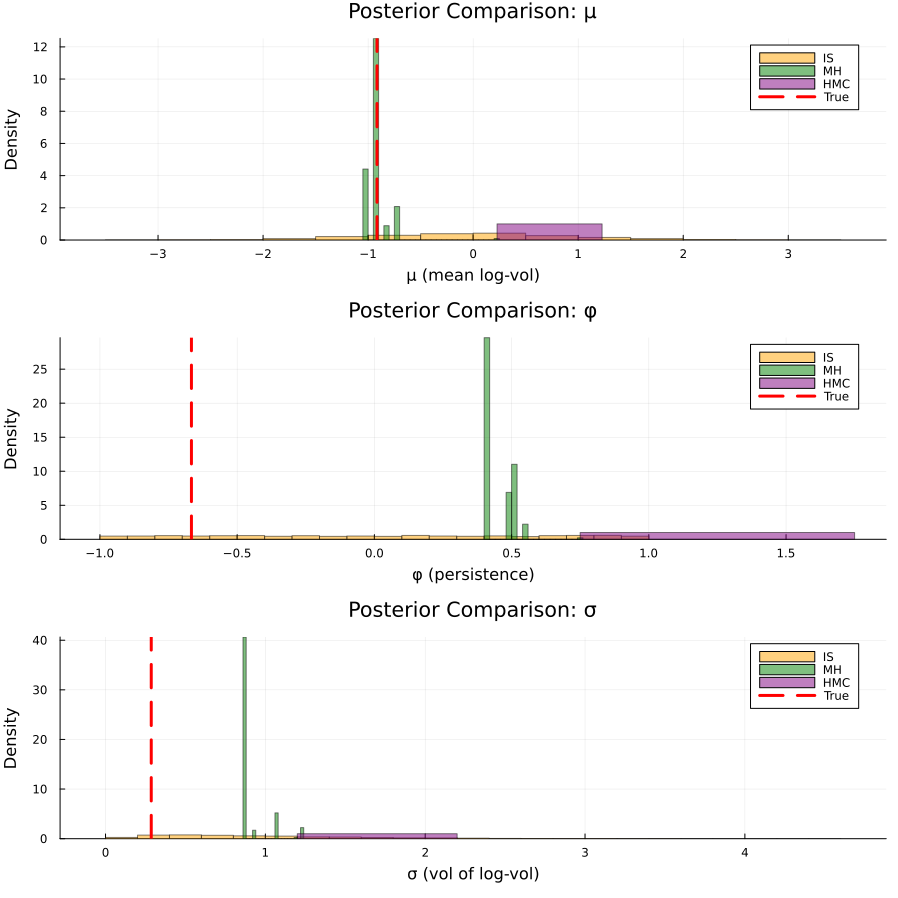

In [463]:
# Visualize parameter posteriors (IS, MH, HMC only — PF uses fixed params)
p1 = histogram(μs, bins=30, normalize=:pdf, alpha=0.5, color=:orange, label="IS")
histogram!(p1, μs_mh, bins=30, normalize=:pdf, alpha=0.5, color=:green, label="MH")
histogram!(p1, μs_hmc, bins=30, normalize=:pdf, alpha=0.5, color=:purple, label="HMC")
vline!(p1, [true_params.μ], color=:red, linewidth=3, linestyle=:dash, label="True")
xlabel!(p1, "μ (mean log-vol)")
ylabel!(p1, "Density")
title!(p1, "Posterior Comparison: μ")

p2 = histogram(φs, bins=30, normalize=:pdf, alpha=0.5, color=:orange, label="IS")
histogram!(p2, φs_mh, bins=30, normalize=:pdf, alpha=0.5, color=:green, label="MH")
histogram!(p2, φs_hmc, bins=30, normalize=:pdf, alpha=0.5, color=:purple, label="HMC")
vline!(p2, [true_params.φ], color=:red, linewidth=3, linestyle=:dash, label="True")
xlabel!(p2, "φ (persistence)")
ylabel!(p2, "Density")
title!(p2, "Posterior Comparison: φ")

p3 = histogram(σs, bins=30, normalize=:pdf, alpha=0.5, color=:orange, label="IS")
histogram!(p3, σs_mh, bins=30, normalize=:pdf, alpha=0.5, color=:green, label="MH")
histogram!(p3, σs_hmc, bins=30, normalize=:pdf, alpha=0.5, color=:purple, label="HMC")
vline!(p3, [true_params.σ], color=:red, linewidth=3, linestyle=:dash, label="True")
xlabel!(p3, "σ (vol of log-vol)")
ylabel!(p3, "Density")
title!(p3, "Posterior Comparison: σ")

plot(p1, p2, p3, layout=(3, 1), size=(900, 900), legend=:topright)

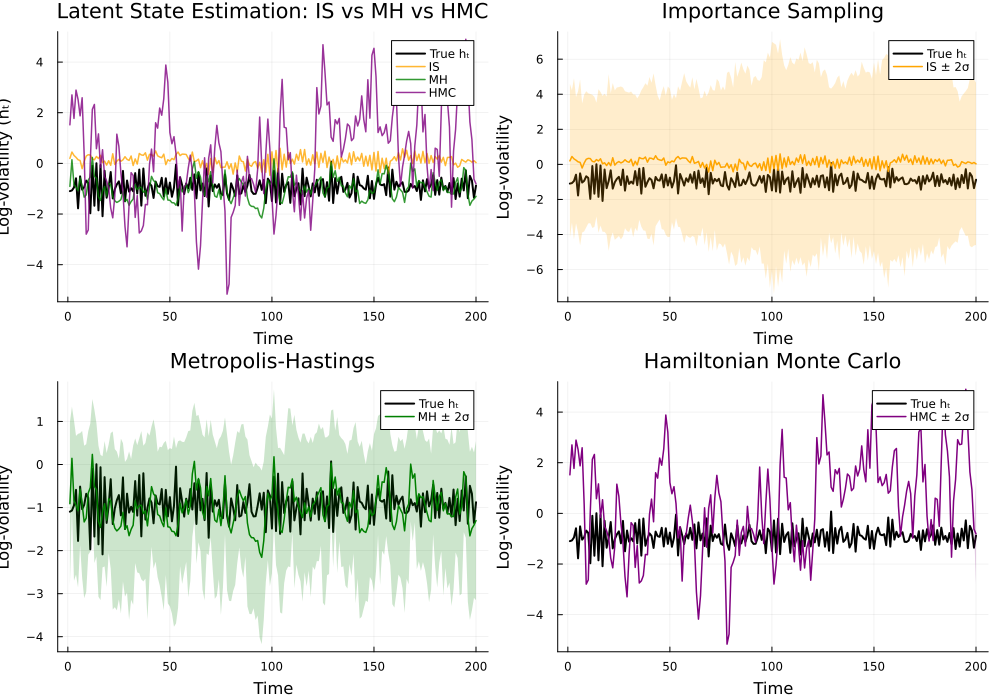

In [475]:
# Visualize latent state (log-volatility) estimation: IS vs MH vs HMC
ts = 1:T

# Plot 1: Mean estimates from all three methods vs true latent states
p1 = plot(ts, h_true, label="True hₜ", color=:black, linewidth=2, alpha=1.0)
plot!(p1, ts, h_is, label="IS", color=:orange, linewidth=1.5, alpha=0.8)
plot!(p1, ts, h_mh, label="MH", color=:green, linewidth=1.5, alpha=0.8)
plot!(p1, ts, h_hmc, label="HMC", color=:purple, linewidth=1.5, alpha=0.8)
xlabel!(p1, "Time")
ylabel!(p1, "Log-volatility (hₜ)")
title!(p1, "Latent State Estimation: IS vs MH vs HMC")

# Plot 2: IS with uncertainty bands
p2 = plot(ts, h_true, label="True hₜ", color=:black, linewidth=2)
plot!(p2, ts, h_is, ribbon=2*h_is_std, 
      label="IS ± 2σ", color=:orange, fillalpha=0.2, linewidth=1.5)
xlabel!(p2, "Time")
ylabel!(p2, "Log-volatility")
title!(p2, "Importance Sampling")

# Plot 3: MH with uncertainty bands
p3 = plot(ts, h_true, label="True hₜ", color=:black, linewidth=2)
plot!(p3, ts, h_mh, ribbon=2*h_mh_std, 
      label="MH ± 2σ", color=:green, fillalpha=0.2, linewidth=1.5)
xlabel!(p3, "Time")
ylabel!(p3, "Log-volatility")
title!(p3, "Metropolis-Hastings")

# Plot 4: HMC with uncertainty bands
p4 = plot(ts, h_true, label="True hₜ", color=:black, linewidth=2)
plot!(p4, ts, h_hmc, ribbon=2*h_hmc_std, 
      label="HMC ± 2σ", color=:purple, fillalpha=0.2, linewidth=1.5)
xlabel!(p4, "Time")
ylabel!(p4, "Log-volatility")
title!(p4, "Hamiltonian Monte Carlo")

# Combined layout
plot(p1, p2, p3, p4, layout=(2, 2), size=(1000, 700), legend=:topright)

# Custom Inference 

In [464]:

# compute log prior density
function logprior_sv(mu, phi, sigma)
    lp = 0.0
    # mu from normal(0, 1)
    lp += Distributions.logpdf(Normal(0.0, 1.0), mu)
    # phi from uniform(-0.99, 0.99)
    if phi <= -0.99 || phi >= 0.99
        return -Inf
    end
    lp += -log(1.98)  # log(1 / (0.99 - (-0.99)))
    # sigma from gamma(2, 0.5)
    if sigma <= 0
        return -Inf
    end
    lp += Distributions.logpdf(Gamma(2.0, 0.5), sigma)
    return lp
end


function sv_particle_filter(y_obs, N, mu, phi, sigma, return_path=true)
T_len = length(y_obs)
    
    # Check parameter validity
    if abs(phi) >= 1.0 || sigma <= 0
        return -Inf, zeros(T_len)
    end
    
    particles = zeros(N, T_len)      # particles[i, t] = h_t for particle i
    ancestors = zeros(Int, N, T_len) # for trajectory sampling
    log_ml = 0.0                     # accumulate log marginal likelihood
    
    # initialize stationaty variance under AR(1)
    h1_std = sigma / sqrt(1 - phi^2)
    for i in 1:N
        particles[i, 1] = mu + h1_std * randn()
        ancestors[i, 1] = i
    end
    
    # Compute weights for first iteration
    # weight of particle time at t=1 is prop to p(y_1 | h_1)
    log_weights = zeros(N)
    for i in 1:N
        y_std = exp(particles[i, 1] / 2)
        log_weights[i] = Distributions.logpdf(Normal(0.0, y_std), y_obs[1])
    end
    
    # Log-sum-exp for marginal likelihood contribution
    max_lw = maximum(log_weights)
    # if all weights are -inf, all weights = 0 
    if max_lw == -Inf
        return -Inf, zeros(T_len)
    end
    log_ml += max_lw + log(mean(exp.(log_weights .- max_lw)))
    
    # Normalize weights to sum to 1
    weights = exp.(log_weights .- max_lw)
    weights ./= sum(weights)
    
    # recursive filtering for the rest of the iterations
    for t in 2:T_len
        # Resample (multinomial)
        # drawp parents according to renormalized weights
        parent_indices = rand(Categorical(weights), N)
        
        # Propagate via prior transition
        # i.e for each new particle, sample from p(h_t | h_{t-1})
        for i in 1:N
            parent = parent_indices[i]
            ancestors[i, t] = parent
            # AR(1) transition mean: mu + phi*(h_{t-1} - mi)

            h_mean = mu + phi * (particles[parent, t-1] - mu)
            particles[i, t] = h_mean + sigma * randn()
        end
        
        # update weights using observation likelihood
        for i in 1:N
            y_std = exp(particles[i, t] / 2)
            log_weights[i] = Distributions.logpdf(Normal(0.0, y_std), y_obs[t])
        end
        
        # Update marginal likelihood
        max_lw = maximum(log_weights)
        if max_lw == -Inf
            return -Inf, zeros(T_len)
        end
        log_ml += max_lw + log(mean(exp.(log_weights .- max_lw)))
        
        # Normalize weights i.e convert the log weights to normalized wiei
        weights = exp.(log_weights .- max_lw)
        total = sum(weights)
        weights = [w / total for w in weights]
    end
    
    h_path = zeros(T_len)
    if return_path
        # Sample final particle proportional to weights
        # same as sampling h_T from p(h_T | y_{1:T})
        idx = rand(Categorical(weights))
        h_path[T_len] = particles[idx, T_len]
        
        # Trace back ancestors to reconstruct 1 sampled path
        for t in (T_len-1):-1:1
            idx = ancestors[idx, t+1]
            h_path[t] = particles[idx, t]
        end
    end
    
    return log_ml, h_path
end

function infer_pmmh(T, y_obs; n_samples = 2000, n_burnin =1000, N_particles = 200, proposal_std =(0.1, 0.05, 0.1),
    adapt_proposals =true)
    
    println("Particle Marginal Metropolis-Hastings (PMMH)")
    println("n_samples=$n_samples, n_burnin=$n_burnin, N_particles=$N_particles")
    println("Initial proposal std: μ=$(proposal_std[1]), φ=$(proposal_std[2]), σ=$(proposal_std[3])")
    
    # Initialization parameters, they dont matter much as the chain is ergodic
    # and will forget them after burn-in
    mu_curr = randn()
    phi_curr = 0.9 * (2 * rand() - 1)  
    sigma_curr = rand(Gamma(2.0, 0.5))
    
    # Run initial PF and compute log prior
    log_ml_curr, h_curr = sv_particle_filter(y_obs, N_particles, mu_curr, phi_curr, sigma_curr, return_path=true)
    log_prior_curr = logprior_sv(mu_curr, phi_curr, sigma_curr)
    
    # Adaptive proposal scales
    # we explore a random walk within the standard deviations given
    mu_std, phi_std, sigma_std = proposal_std
    
    # each sample is a named tuple of (mu, phi, sigma, h_path)
    # where h_path is the sampled trajectory at these parameters
    samples = Vector{NamedTuple{(:mu, :phi, :sigma, :h), Tuple{Float64, Float64, Float64, Vector{Float64}}}}()
    
    # track acceptance rates
    accept_count = 0
    window_size = 100
    accept_window = zeros(window_size)
    
    total_iters = n_burnin + n_samples
    
    
    for iter in 1:total_iters

        # symmetric random walks where epsilon is a Normal (0, std)
        mu_prop = mu_curr + mu_std * randn()
        phi_prop = phi_curr + phi_std * randn()
        sigma_prop = sigma_curr + sigma_std * randn()
        
        log_prior_prop = logprior_sv(mu_prop, phi_prop, sigma_prop)
        
        #if logpriors are negative, immediately reject
        if log_prior_prop == -Inf
            
            accepted = false
        else
            # Run PF for proposed parameters
            # log_ml_prop is a PF estimate of p(y | theta_prop)
            # h_prop is one samplle of h1 to hT from p(h | y, theta_prop)
            # MH only needs the log_ml_prop 
            # h_ prop is just for plotting
            log_ml_prop, h_prop = sv_particle_filter(y_obs, N_particles, mu_prop, phi_prop, sigma_prop, return_path=true)
            
            if log_ml_prop == -Inf
                accepted = false
            else
                # MH acceptance ratio (symmetric proposals, so proposal density terms cancel out)
                log_accept = (log_prior_prop + log_ml_prop) - (log_prior_curr + log_ml_curr)
                
                if log(rand()) < log_accept
                    # Accept -> move to proposed params in chain
                    mu_curr, phi_curr, sigma_curr = mu_prop, phi_prop, sigma_prop
                    h_curr = h_prop
                    log_ml_curr = log_ml_prop
                    log_prior_curr = log_prior_prop
                    accepted = true
                else
                    accepted = false
                end
            end
        end
        
        # track acceptance in a sliding window so we can adapt proposal parameters
        accept_window[mod1(iter, window_size)] = accepted ? 1.0 : 0.0
        if accepted
            accept_count += 1
        end
        
        #Adapt proposals during burn-in
        # this tries to keep acceptance in the window we arrived at after some experimentation
        if adapt_proposals && iter <= n_burnin && iter >= window_size && iter % window_size == 0
            accept_rate = mean(accept_window)
            
            # if proposal too low, make bigger riskier steps
            if accept_rate < 0.20
                mu_std *= 0.8
                phi_std *= 0.8
                sigma_std *= 0.8
            # if proposal too high, make smaller steps
            elseif accept_rate > 0.45
                mu_std *= 1.2
                phi_std *= 1.2
                sigma_std *= 1.2
            end
            
            # Clamp proposal standard deviations
            mu_std = clamp(mu_std, 0.001, 1.0)
            phi_std = clamp(phi_std, 0.005, 0.99)
            sigma_std = clamp(sigma_std, 0.001, 0.99)
        end
        
        # only collect samples after burn-in because we want to have a stationary distribution
        if iter > n_burnin
            push!(samples, (μ=mu_curr, φ=phi_curr, σ=sigma_curr, h=copy(h_curr)))
        end
        
    end
    
    final_accept = accept_count / total_iters
    println("PMMH Report")
    println("  Total acceptance rate: $(final_accept)")
    println("  Final proposal std: μ=$(mu_std), φ=$(phi_std), σ=$(sigma_std)")
    println("  Collected $(length(samples)) posterior samples")
    
    return samples
end

infer_pmmh (generic function with 2 methods)

In [465]:
# Run PMMH inference
println("Running Particle Marginal Metropolis-Hastings...")

Random.seed!(123)
@time samples_pmmh = infer_pmmh(T, y,
    n_samples=2000,
    n_burnin=1000,
    N_particles=200,
    proposal_std=(0.15, 0.05, 0.1),
    adapt_proposals=true)

println("\nNumber of posterior samples (PMMH): $(length(samples_pmmh))")


Running Particle Marginal Metropolis-Hastings...
Particle Marginal Metropolis-Hastings (PMMH)
n_samples=2000, n_burnin=1000, N_particles=200
Initial proposal std: μ=0.15, φ=0.05, σ=0.1
PMMH Report
  Total acceptance rate: 0.35233333333333333
  Final proposal std: μ=0.216, φ=0.072, σ=0.144
  Collected 2000 posterior samples
  5.094298 seconds (5.81 M allocations: 7.547 GiB, 12.47% gc time)

Number of posterior samples (PMMH): 2000


In [466]:
# Extract parameters from PMMH posterior samples
μs_pmmh = [s.μ for s in samples_pmmh]
φs_pmmh = [s.φ for s in samples_pmmh]
σs_pmmh = [s.σ for s in samples_pmmh]

println("PMMH Posterior parameter estimates (mean ± std):")
println("  μ (mean log-vol):    $(round(mean(μs_pmmh), digits=4)) ± $(round(std(μs_pmmh), digits=4))  (true: $(round(true_params.μ, digits=4)))")
println("  φ (persistence):     $(round(mean(φs_pmmh), digits=4)) ± $(round(std(φs_pmmh), digits=4))  (true: $(round(true_params.φ, digits=4)))")
println("  σ (vol of log-vol):  $(round(mean(σs_pmmh), digits=4)) ± $(round(std(σs_pmmh), digits=4))  (true: $(round(true_params.σ, digits=4)))")

PMMH Posterior parameter estimates (mean ± std):
  μ (mean log-vol):    -1.0075 ± 0.1075  (true: -0.9152)
  φ (persistence):     -0.5147 ± 0.3934  (true: -0.6666)
  σ (vol of log-vol):  0.3541 ± 0.1398  (true: 0.2861)


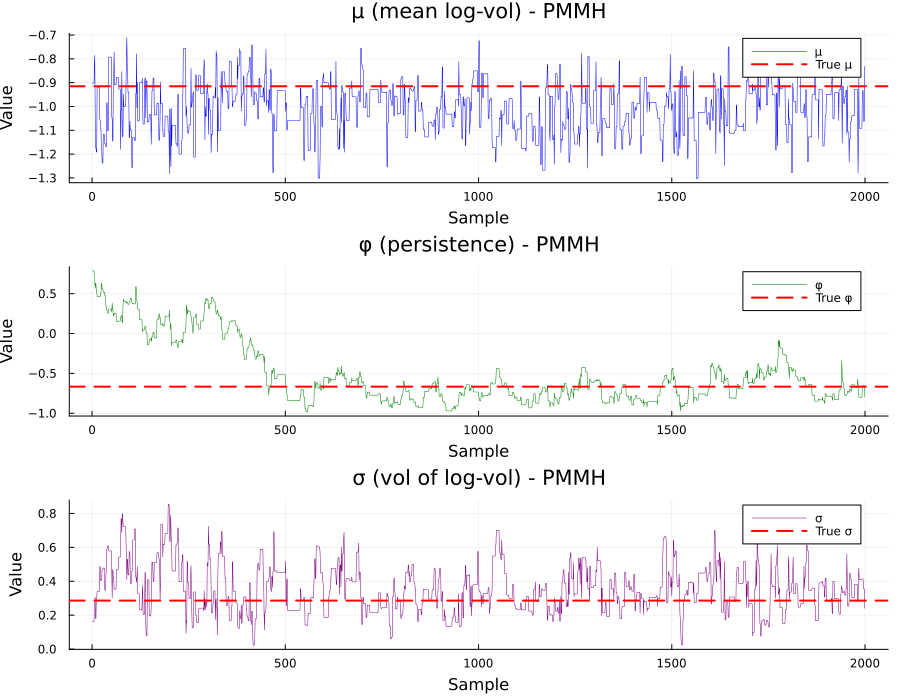

In [467]:
# Trace plots for PMMH diagnostics
p1 = plot(μs_pmmh, label="μ", xlabel="Sample", ylabel="Value", 
          title="μ (mean log-vol) - PMMH", linewidth=0.5, color=:blue)
hline!(p1, [true_params.μ], label="True μ", linestyle=:dash, color=:red, linewidth=2)

p2 = plot(φs_pmmh, label="φ", xlabel="Sample", ylabel="Value", 
          title="φ (persistence) - PMMH", linewidth=0.5, color=:green)
hline!(p2, [true_params.φ], label="True φ", linestyle=:dash, color=:red, linewidth=2)

p3 = plot(σs_pmmh, label="σ", xlabel="Sample", ylabel="Value", 
          title="σ (vol of log-vol) - PMMH", linewidth=0.5, color=:purple)
hline!(p3, [true_params.σ], label="True σ", linestyle=:dash, color=:red, linewidth=2)

plot(p1, p2, p3, layout=(3, 1), size=(900, 700), legend=:topright)

In [468]:
# Extract latent states from PMMH posterior samples
# PMMH already provides full trajectories via ancestor tracing!
h_samples_pmmh = [s.h for s in samples_pmmh]

# Compute mean and std of latent states
h_pmmh = [mean([h[t] for h in h_samples_pmmh]) for t in 1:T]
h_pmmh_std = [std([h[t] for h in h_samples_pmmh]) for t in 1:T]

println("PMMH provides $(length(h_samples_pmmh)) full latent trajectories via ancestor tracing")
println("Latent state mean range: [$(round(minimum(h_pmmh), digits=2)), $(round(maximum(h_pmmh), digits=2))]")

PMMH provides 2000 full latent trajectories via ancestor tracing
Latent state mean range: [-1.47, -0.34]


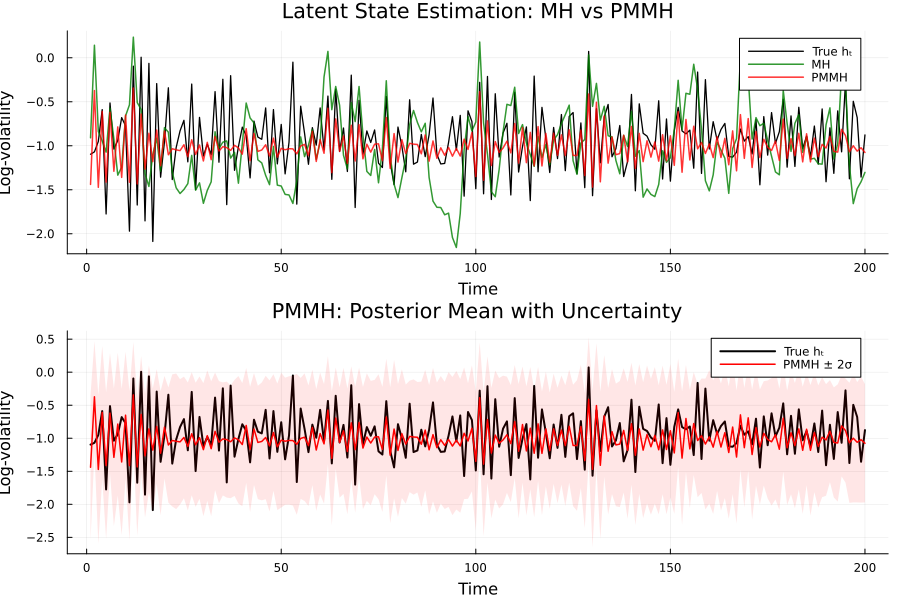

In [476]:
# Compare PMMH vs MH: Latent States
ts = 1:T

p1 = plot(ts, h_true, label="True hₜ", color=:black, linewidth=1.3, alpha=1)
plot!(p1, ts, h_mh, label="MH", color=:green, linewidth=1.5, alpha=0.8)
plot!(p1, ts, h_pmmh, label="PMMH", color=:red, linewidth=1.5, alpha=0.8)
xlabel!(p1, "Time")
ylabel!(p1, "Log-volatility")
title!(p1, "Latent State Estimation: MH vs PMMH")

# Uncertainty bands for PMMH
p2 = plot(ts, h_true, label="True hₜ", color=:black, linewidth=2)
plot!(p2, ts, h_pmmh, ribbon=2*h_pmmh_std, 
      label="PMMH ± 2σ", color=:red, fillalpha=0.1, linewidth=1.5)
xlabel!(p2, "Time")
ylabel!(p2, "Log-volatility")
title!(p2, "PMMH: Posterior Mean with Uncertainty")

plot(p1, p2, layout=(2, 1), size=(900, 600), legend=:topright)

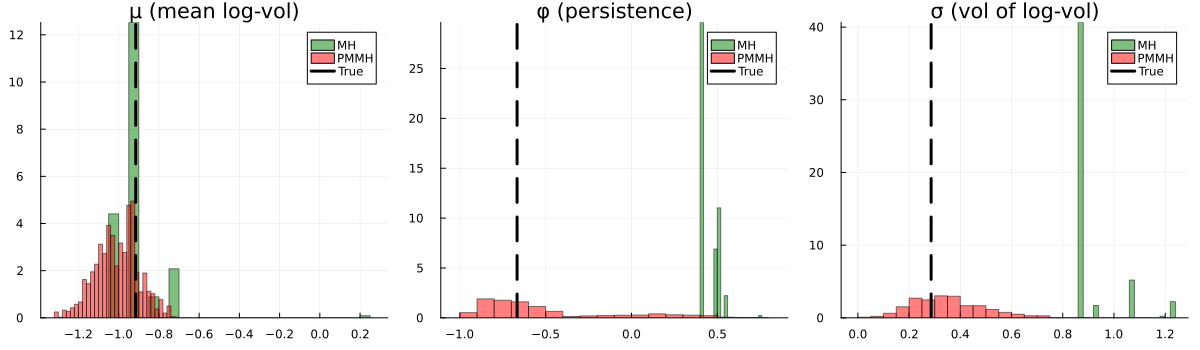

In [477]:
# Compare parameter posteriors: MH vs PMMH
p1 = histogram(μs_mh, bins=30, normalize=:pdf, alpha=0.5, color=:green, label="MH")
histogram!(p1, μs_pmmh, bins=30, normalize=:pdf, alpha=0.5, color=:red, label="PMMH")
vline!(p1, [true_params.μ], color=:black, linewidth=3, linestyle=:dash, label="True")
xlabel!(p1, "μ")
title!(p1, "μ (mean log-vol)")

p2 = histogram(φs_mh, bins=30, normalize=:pdf, alpha=0.5, color=:green, label="MH")
histogram!(p2, φs_pmmh, bins=30, normalize=:pdf, alpha=0.5, color=:red, label="PMMH")
vline!(p2, [true_params.φ], color=:black, linewidth=3, linestyle=:dash, label="True")
xlabel!(p2, "φ")
title!(p2, "φ (persistence)")

p3 = histogram(σs_mh, bins=30, normalize=:pdf, alpha=0.5, color=:green, label="MH")
histogram!(p3, σs_pmmh, bins=30, normalize=:pdf, alpha=0.5, color=:red, label="PMMH")
vline!(p3, [true_params.σ], color=:black, linewidth=3, linestyle=:dash, label="True")
xlabel!(p3, "σ")
title!(p3, "σ (vol of log-vol)")

plot(p1, p2, p3, layout=(1, 3), size=(1200, 350), legend=:topright)

In [471]:
# Summary comparison: HMC vs PMMH
mse_pmmh = mean((h_pmmh .- h_true).^2)
mae_pmmh = mean(abs.(h_pmmh .- h_true))

println("COMPARISON: HMC vs PMMH (Particle Marginal Metropolis-Hastings)")

println("\nLatent State Estimation:")
println("Method  | MSE      | MAE")
println("HMC     | $(round(mse_hmc, digits=4))  | $(round(mean(abs.(h_hmc .- h_true)), digits=4))")
println("PMMH    | $(round(mse_pmmh, digits=4))  | $(round(mae_pmmh, digits=4))")
println("PF*     | $(round(mse_pf, digits=4))  | $(round(mae_pf, digits=4))  (* uses true params)")

println("\nParameter Estimation:")
println("Parameter | True     | HMC                 | PMMH")
println("μ         | $(round(true_params.μ, digits=4))  | $(round(mean(μs_hmc), digits=4)) ± $(round(std(μs_hmc), digits=4))  | $(round(mean(μs_pmmh), digits=4)) ± $(round(std(μs_pmmh), digits=4))")
println("φ         | $(round(true_params.φ, digits=4))  | $(round(mean(φs_hmc), digits=4)) ± $(round(std(φs_hmc), digits=4))  | $(round(mean(φs_pmmh), digits=4)) ± $(round(std(φs_pmmh), digits=4))")
println("σ         | $(round(true_params.σ, digits=4))  | $(round(mean(σs_hmc), digits=4)) ± $(round(std(σs_hmc), digits=4))  | $(round(mean(σs_pmmh), digits=4)) ± $(round(std(σs_pmmh), digits=4))")

# Parameter errors comparison
μ_err_pmmh = abs(mean(μs_pmmh) - true_params.μ)
φ_err_pmmh = abs(mean(φs_pmmh) - true_params.φ)
σ_err_pmmh = abs(mean(σs_pmmh) - true_params.σ)

println("\nAbsolute Errors:")
println("μ error   | HMC: $(round(μ_err_hmc, digits=4))  | PMMH: $(round(μ_err_pmmh, digits=4))")
println("φ error   | HMC: $(round(φ_err_hmc, digits=4))  | PMMH: $(round(φ_err_pmmh, digits=4))")
println("σ error   | HMC: $(round(σ_err_hmc, digits=4))  | PMMH: $(round(σ_err_pmmh, digits=4))")


COMPARISON: HMC vs PMMH (Particle Marginal Metropolis-Hastings)

Latent State Estimation:
Method  | MSE      | MAE
HMC     | 5.3987  | 1.8854
PMMH    | 0.1311  | 0.287
PF*     | 0.137  | 0.3003  (* uses true params)

Parameter Estimation:
Parameter | True     | HMC                 | PMMH
μ         | -0.9152  | 0.2276 ± 0.0  | -1.0075 ± 0.1075
φ         | -0.6666  | 0.7498 ± 0.0  | -0.5147 ± 0.3934
σ         | 0.2861  | 1.1998 ± 0.0  | 0.3541 ± 0.1398

Absolute Errors:
μ error   | HMC: 1.1428  | PMMH: 0.0923
φ error   | HMC: 1.4164  | PMMH: 0.1519
σ error   | HMC: 0.9137  | PMMH: 0.068
